**Visual Inspection of LOC EEG Data**

This notebook performs the visual quality check of the LOC EEG recordings after BIDS conversion. The goal is to assess data quality & interpolate bad channels before proceeding to the next preprocessing steps.

Specifally, this notebook:
- loads the BIDS-formatted EEG data
- extracts and visually inspects the recorded events
- evaluates power line noise using PSD plots
- adds manual and automatic annotations, including:
a. break periods 
b. muscular activity (EMG) artifacts 
c. bad channels

Things I need to do:
[] Clean-up the section where annotations are saved
[] I also wanna save the output file of the downsampling. Naming conventions and where to save? Check with BIDS requirements.
[] Check where I should output the annotations .csv file to.
[] Set up and run bad channel selection and interpolation

In [3]:
## Import required libraries

# Standard library
from pathlib import Path
import os

# Numeric computing
import numpy as np

# MNE core
import mne
from mne.channels import make_standard_montage
from mne.preprocessing import ICA, annotate_break

# BIDS handling
from mne_bids import BIDSPath, read_raw_bids

In [4]:
# Get working tree and eeg files for the project
bids_root = Path(r"C:\Users\noahm\projects\loc_analysis\data\derivatives")
datatype = "eeg"
bids_path = BIDSPath(root=bids_root, datatype=datatype)
print(bids_path)

C:/Users/noahm/projects/loc_analysis/data/derivatives/eeg


In [5]:
# Prepare for reading the data for the participant
task = "loc"
suffix = "eeg"
sub_number = "01"
bids_path = bids_path.update(subject=sub_number, task=task, suffix=suffix)

In [6]:
# Read data file
raw_eeg = read_raw_bids(bids_path=bids_path, verbose=False)
print(raw_eeg.info)

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 63 EEG, 2 EOG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 66 items (3 Cardinal, 63 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 280.0 Hz
 meas_date: 2025-12-02 11:40:38 UTC
 nchan: 65
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: sub-01, sex: 0, hand: 0>
>


C:\Users\noahm\AppData\Local\Temp\ipykernel_24468\2498266073.py:2: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['HEOG', 'VEOG']
  raw_eeg = read_raw_bids(bids_path=bids_path, verbose=False)
C:\Users\noahm\AppData\Local\Temp\ipykernel_24468\2498266073.py:2: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['HEOG', 'VEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = read_raw_bids(bids_path=bids_path, verbose=False)


In [7]:
# Juan suggested downsampling the data as one of first steps for easier visual inspection.
print(f"Original sampling rate: {raw_eeg.info['sfreq']} Hz")

Original sampling rate: 1000.0 Hz


In [8]:
# https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html advises to perform resampling on the 
# Raw object and its corresponding Events array simultaneously so that they stay in sync.
events, event_id = mne.events_from_annotations(raw_eeg, verbose=False)
raw_eeg, events = raw_eeg.resample(500, events=events)

print(f"New sampling rate: {raw_eeg.info['sfreq']} Hz")

New sampling rate: 500.0 Hz


C:\Users\noahm\AppData\Local\Temp\ipykernel_24468\898595423.py:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events, sfreq=raw_eeg.info["sfreq"], first_samp=raw_eeg.first_samp, event_id=event_id)


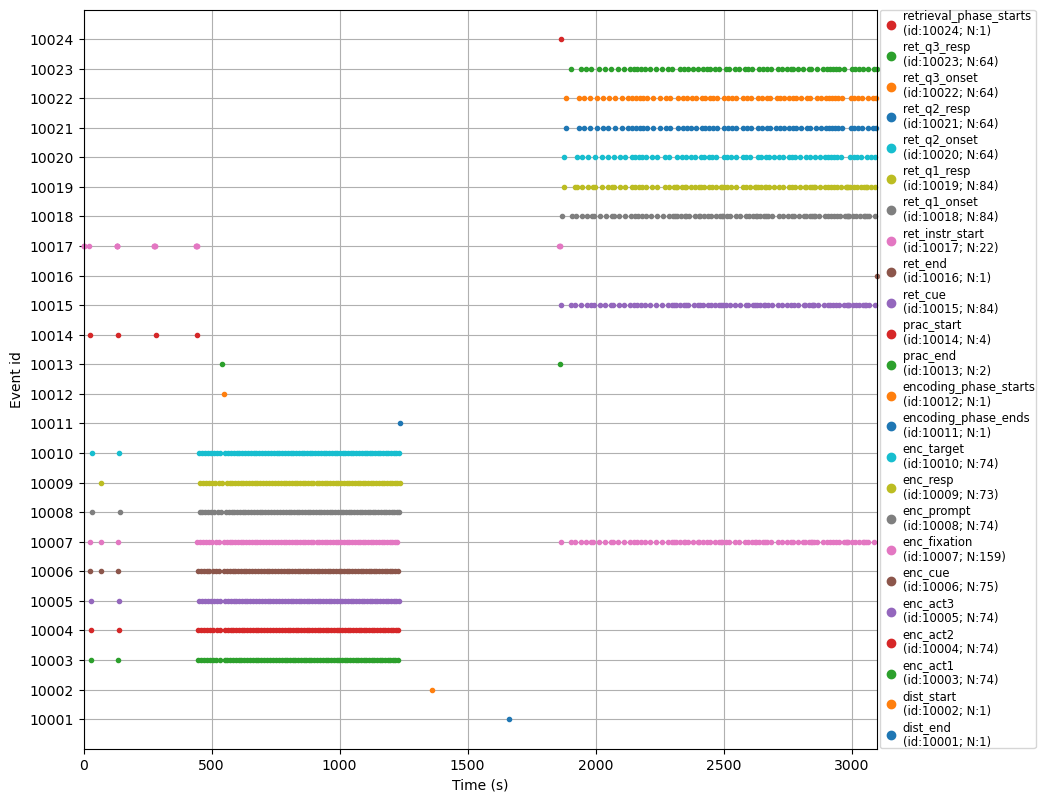

In [9]:
# Plot events
# events, event_id = mne.events_from_annotations(raw_eeg, verbose=False)
fig = mne.viz.plot_events(events, sfreq=raw_eeg.info["sfreq"], first_samp=raw_eeg.first_samp, event_id=event_id)

In case, you've already did some annotations you can load them with this code chunk:

# ---------------------------------------------------------
# Load the CSV file
csv_filename = "loc-01_saved-annotations.csv" # Update if your filename is different
my_saved_annots = mne.read_annotations(csv_filename)

# Apply them to the raw object
# This replaces the "Stimulus" text labels with your "BAD_" segments
raw_eeg.set_annotations(my_saved_annots)

# ---------------------------------------------------------
# 4. Visualize
# ---------------------------------------------------------
# We pass 'events' so we see the vertical lines
# We pass 'event_id' for the trigger map
scaling_dict = dict(eeg=20e-6)

raw_eeg.plot(
    events=events, 
    event_id=event_id,
    duration=10, 
    scalings=scaling_dict
)

Some notes on the triggers for pilot_01:
- All the trigger codes that we defined, were sent through BUT 299 for ret_end (> 255) --> it was recoded to 43 = 299-256
- Clear demarcations of encoding (100-199), distractor (50-51), and retrieval phase (200-255)
- Trigger 1: Why are there so many? It should only encode "enc_instr_starts" and "ret_instr_starts"
- What's up with practice? Prac_start = 2, prac_end = 3. There should only be one for both of those.
- What is going on with the 100s BEFORE encoding starts at 100? 
- 101 seems to encode all fixation crosses. Maybe we should distinguish between encoding and retrieval.
- Trigger codes 102 to 108 should all have exactly the same N (cue, act1, act2,.., resp). Do we have 10 practice trials? Then, it should be N=74. Deviations at 102 = enc_cue, and 108 = enc_resp.
- Retrieval phase looks good.. I assume cue(201), seen before (202,203) appear 84 times because 20 new lures are included?
- Ivan suggests that trigger codes should reflect different encoding conditions... he was not sure how we could recode this later.

- For more systematic checking, I could implement a function that compares the length of a specific trigger to the corresponding column of the dataframe.

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


c:\Users\noahm\mne-python\1.11.0_0\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


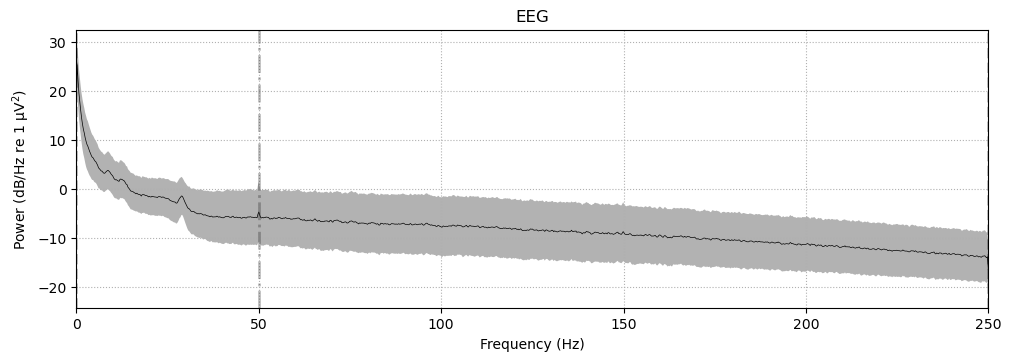

In [10]:
# Look at power line noise
fig = raw_eeg.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, picks="data", exclude="bads"
)

In [43]:
# ---------------------------------------------------------
# STEP 0: PRESERVE THE ORIGINAL STIMULUS MARKERS
# ---------------------------------------------------------
# We make a copy of the annotations (which contain the BIDS triggers)
# so we can add them back later.
stimulus_annotations = raw_eeg.annotations.copy()

# 1. Define your Event IDs of interest
id_enc_start  = 10012  # End of first break = encoding_phase_starts
id_dist_start = 10011  # Start of second break = encoding_phase_ends
id_dist_end   = 10024  # End of second break = retrieval_phase_start

# 2. Get the sample indices for these events
# We use np.where to find the index in the events array where the ID matches
# events[:, 0] are samples, events[:, 2] are IDs

# Find sample for Encoding Start (Event 10012)
# We take [0][0] to get the first occurrence found
samp_enc_start = events[events[:, 2] == id_enc_start, 0][0]

# Find samples for Distractor Phase (10002 to 10001)
samp_dist_start = events[events[:, 2] == id_dist_start, 0][0]
samp_dist_end   = events[events[:, 2] == id_dist_end, 0][0]

# 3. Calculate Onsets and Durations (in seconds)
sfreq = raw_eeg.info['sfreq']
first_samp = raw_eeg.first_samp

# Break 1: From start of file (or first_samp) to Encoding Start
onset_1 = 0  # Relative to recording start
duration_1 = (samp_enc_start - first_samp) / sfreq

# Break 2: From Distractor Start to Distractor End
onset_2 = (samp_dist_start - first_samp) / sfreq
duration_2 = (samp_dist_end - samp_dist_start) / sfreq

# 4. Create the Annotations object
my_breaks = mne.Annotations(
    onset=[onset_1, onset_2],
    duration=[duration_1, duration_2],
    description=['BAD_break', 'BAD_distractor'] # 'BAD_' prefix ensures MNE ignores these segments automatically
)

# 5. Apply to Raw
raw_eeg.set_annotations(my_breaks)

# Here, we open the raw file to verify and to manually annotate muscular artifacts 
# Open the plot always with the same parameter, so its an objective comparison between participants
# Create a new description called 'BAD_Muscle' and drag-and-drop intervals with excessive muscle noise..
scaling_dict = dict(eeg=20e-6)
fig = raw_eeg.plot(duration=10, n_channels=32, scalings=scaling_dict)
fig.fake_keypress("a") # Automatically entering annotation mode

Channels marked as bad:
none


In [2]:
# ---------------------------------------------------------
# STEP 4: MERGE EVERYTHING
# ---------------------------------------------------------
# raw_eeg.annotations now contains: [Breaks + Muscle]
# stimulus_annotations contains:    [Original Triggers]

# Combine them
all_annotations = raw_eeg.annotations + stimulus_annotations

# Apply back to raw
raw_eeg.set_annotations(all_annotations)

# ---------------------------------------------------------
# STEP 5: VERIFY
# ---------------------------------------------------------
# Now plot WITH events to see everything together
# You should see: Vertical Event lines + Red Breaks + Red Muscle
raw_eeg.plot(events=events, duration=10, scalings=scaling_dict)

NameError: name 'raw_eeg' is not defined

In [1]:
# Store annotations in a new variable 
# interactive_annot = raw_eeg.annotations
interactive_annot = all_annotations
# Save the annotations to a file
raw_eeg.annotations.save(f"loc-{sub_number}_saved-annotations_2.csv", overwrite=True)
# Set new annot to a copy of the data
raw_annotated = raw_eeg.copy().set_annotations(interactive_annot)

NameError: name 'all_annotations' is not defined

Now, that the breaks have been annotated & we see the raw signal without the triggers, it's a good time to mark the EMG artefacts in the signal. Afterwards, we can merge the EEG again with the stimulus annotations.

Tip for later: you can save intermediate steps of your preprocessing - this helps with chunking of code.
If later you want to only change 1 step of your preprocessing pipeline, you can import data or annotations up until that point.

In [24]:
# We can store different versions of our annotations in a file
raw_eeg.annotations.save("saved-annotations.csv", overwrite=True)
# Then access it again using the read_annotations function
annot_from_file = mne.read_annotations("saved-annotations.csv")
# And assign it to the raw data
raw_eeg.set_annotations(annot_from_file)

<RawBrainVision | sub-01_task-loc_eeg.eeg, 65 x 3109760 (3109.8 s), ~96 kB, data not loaded>

In [ ]:
# Then access it again using the read_annotations function
annot_from_file = mne.read_annotations("saved-annotations.csv")
# And assign it to the raw data
raw_eeg.set_annotations(annot_from_file)

### Bad channels


There's a variety of ways to spot bad channels - we saw in the inspection of the raw data that EEG 053 does not pick up any signal. 
Another way to detect a dead channel or one that drifts a lot is to plot an epoch average of all channels:

In [ ]:
# Have a look at topoplots to see if any channels draw attention
events, event_dict = mne.events_from_annotations(raw_annotated)
epochs = mne.Epochs(
    raw_annotated,
    events,
    event_id=event_dict,
    tmin=-0.5,
    tmax=1,
    reject_by_annotation=True, # default parameter
)['enc_target'].average().plot_topomap(show_names=True, size=3)

In [ ]:
# Using spherical spline interpolation, interpolate the channels selected as bad
raw_interp = raw_annotated.load_data().copy().interpolate_bads(reset_bads=True)

# Plot the Evoked data to see if the bad channels have been successfully interpolated
events, event_dict = mne.events_from_annotations(raw_annotated)
epochs = mne.Epochs(
    raw_annotated,
    events,
    event_id=event_dict,
    tmin=-0.5,
    tmax=1,
    reject_by_annotation=True, # default parameter
)['enc_target'].average().plot()

If I am reloading previously annotated data, load the annotations here:

In [ ]:
annot_from_file = mne.read_annotations(f"/mnt/NeuroNas/ivan/InstrAct_EEG/data/derivatives/sub-{sub_number}/sub-{sub_number}_saved-annotations.csv")
raw_annotated = raw.copy().set_annotations(annot_from_file)